In [1]:
from pathlib import Path
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(Path().resolve(), '../..')))
from ImportHelper import ImportHelper
ImportHelper()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
#from tensorflow import keras
from sklearn import preprocessing
from AlphaVantageCommodities import AlphaVantageCommodities
from PandasDataFrameNormalizer import PandasDataFrameNormalizer
from WtiPredictionDays import WtiPredictionDays
from dotenv import load_dotenv
import seaborn as sns
import datetime

load_dotenv()

2023-12-15 17:06:23.203160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 17:06:23.203246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 17:06:23.203274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 17:06:23.213529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

avc_selected_symbols: ['WTI', 'BRENT', 'NATURAL_GAS']
print data for each symbol


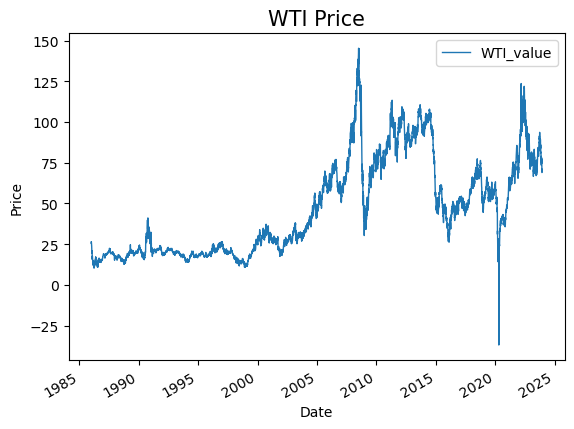

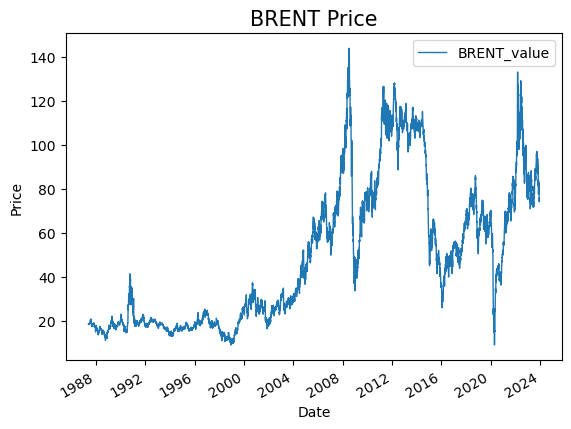

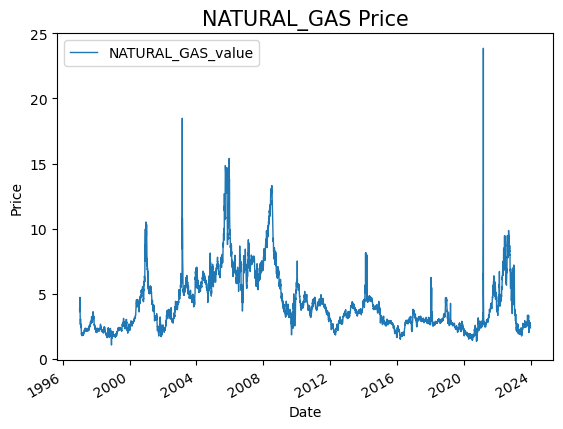

In [3]:
avc = AlphaVantageCommodities()
wti_prediction_days = WtiPredictionDays(verbose=True)
wti_prediction_days.set_nan_handling(nan_handling = 'fill')
df = wti_prediction_days.create_data_collection()

In [4]:
df.head()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
0,1986-01-02,25.559999,NaN,NaN
1,1986-01-03,26.000000,NaN,NaN
2,1986-01-06,26.530001,NaN,NaN
3,1986-01-07,25.850000,NaN,NaN
4,1986-01-08,25.870001,NaN,NaN


In [5]:
wti_prediction_days.set_date_range_limits(start ='2018-01-01')
df = wti_prediction_days.data_collection_preprocessing(df)

show df.head() before preprocessing: 
        date  WTI_value  BRENT_value  NATURAL_GAS_value
0 1986-01-02  25.559999          NaN                NaN
1 1986-01-03  26.000000          NaN                NaN
2 1986-01-06  26.530001          NaN                NaN
3 1986-01-07  25.850000          NaN                NaN
4 1986-01-08  25.870001          NaN                NaN
show df.head() after preprocessing: 
        date  WTI_value  BRENT_value  NATURAL_GAS_value
0 2018-01-02  60.369999    66.650002               6.24
1 2018-01-03  61.610001    67.849998               6.24
2 2018-01-04  61.980000    68.730003               4.65
3 2018-01-05  61.490002    68.010002                NaN
4 2018-01-08  61.730000    68.480003               2.89


In [6]:
df = wti_prediction_days.data_collection_normalization(df, ignore_columns=['date'])

show df.head() before normalization: 
        date  WTI_value  BRENT_value  NATURAL_GAS_value
0 2018-01-02  60.369999    66.650002               6.24
1 2018-01-03  61.610001    67.849998               6.24
2 2018-01-04  61.980000    68.730003               4.65
3 2018-01-05  61.490002    68.010002                NaN
4 2018-01-08  61.730000    68.480003               2.89
create new normalizer for column: WTI_value
normalize column: WTI_value
create new normalizer for column: BRENT_value
normalize column: BRENT_value
create new normalizer for column: NATURAL_GAS_value
normalize column: NATURAL_GAS_value
show df.head() after normalization: 
        date  WTI_value  BRENT_value  NATURAL_GAS_value
0 2018-01-02   0.606089     0.463727           0.217932
1 2018-01-03   0.613809     0.473400           0.217932
2 2018-01-04   0.616113     0.480493           0.147359
3 2018-01-05   0.613062     0.474690          -1.000000
4 2018-01-08   0.614556     0.478478           0.069241


In [7]:
x_train, y_train, x_test, y_test = wti_prediction_days.split_data_collection_into_numpy_arrays(df)

In [8]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train, y_train, sequence_length=wti_prediction_days.features_sequence_length, sampling_rate=wti_prediction_days.sampling_rate, batch_size=wti_prediction_days.batch_size)

2023-12-15 17:06:26.492262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 17:06:26.499069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 17:06:26.499366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 17:06:26.503371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-15 17:06:26.503828: I tensorflow/compile

In [9]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test, y_test, sequence_length=wti_prediction_days.features_sequence_length, sampling_rate=wti_prediction_days.sampling_rate, batch_size=wti_prediction_days.batch_size)

In [10]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 60, 3)
Target shape: (32,)


In [11]:
model = Sequential()

model.add(InputLayer(input_shape = (inputs.shape[1], inputs.shape[2])))

model.add(Masking(mask_value=-1))
#model.add(Dropout(0.2))

model.add(Dense(inputs.shape[2], kernel_initializer='he_uniform'))

#model.add(BatchNormalization())

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.2))

#model.add(LSTM(units = 200, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 200, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 50))
#model.add(Dropout(0.2))

model.add(Dense(units = 1, activation='linear'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_logarithmic_error", metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 60, 3)             0         
                                                                 
 dense (Dense)               (None, 60, 3)             12        
                                                                 
 lstm (LSTM)                 (None, 60, 100)           41600     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 dense_1 (Dense)             (None, 60, 1)             1

In [12]:
dt = datetime.datetime.now()
path_checkpoint = str(dt) + "_model_multi_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

In [13]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [14]:
history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2023-12-15 17:06:35.011282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-15 17:06:36.186801: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd6c832e7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 17:06:36.186859: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-12-15 17:06:36.192187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-15 17:06:36.274378: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/34 [============================>.] - ETA: 0s - loss: 0.0277 - root_mean_squared_error: 0.2375 - mean_absolute_error: 0.1656 - mean_squared_error: 0.0564
Epoch 1: val_loss improved from inf to 0.01129, saving model to 2023-12-15 17:06:28.747675_model_multi_checkpoint.h5
34/34 [==============================] - 12s 127ms/step - loss: 0.0275 - root_mean_squared_error: 0.2372 - mean_absolute_error: 0.1648 - mean_squared_error: 0.0561 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1682 - val_mean_absolute_error: 0.1358 - val_mean_squared_error: 0.0281
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.1358 - mean_absolute_error: 0.0955 - mean_squared_error: 0.0184
Epoch 2: val_loss did not improve from 0.01129
34/34 [==============================] - 1s 44ms/step - loss: 0.0083 - root_mean_squared_error: 0.1362 - mean_absolute_error: 0.0961 - mean_squared_error: 0.0187 - val_loss: 0.0156 - val_root_mean_squared_error: 0.2150 - v

In [15]:
#history.history

<Axes: >

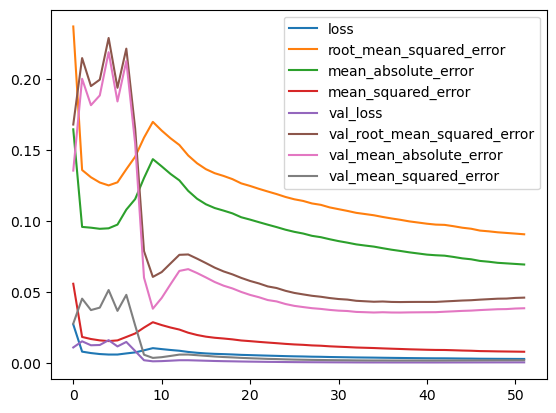

In [16]:
pd.DataFrame(history.history).plot()

In [17]:
model.load_weights(path_checkpoint)
# Re-evaluate the model
loss, rmse, mae, mse = model.evaluate(dataset_test, verbose=2)

6/6 - 0s - loss: 7.1225e-04 - root_mean_squared_error: 0.0433 - mean_absolute_error: 0.0361 - mean_squared_error: 0.0021 - 143ms/epoch - 24ms/step


In [28]:
def plot(input_data, predicted_data, output_compare, limit_right=None):
    if limit_right is not None:
        input_data = input_data[:limit_right]
        predicted_data = predicted_data[:limit_right]
        output_compare = output_compare[:limit_right]
        
    compare_y_shift = wti_prediction_days.features_sequence_length + wti_prediction_days.forecast_days
    compare_y = list(range(compare_y_shift, compare_y_shift+ len(output_compare)))
    
    predicted_y_shift = wti_prediction_days.features_sequence_length + wti_prediction_days.forecast_days
    predicted_y = list(range(predicted_y_shift, predicted_y_shift + len(predicted_data)))
    
    #input_data_limit = wti_prediction_days.features_sequence_length

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(predicted_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(wti_prediction_days.features_sequence_length, input_data[wti_prediction_days.features_sequence_length-1], "rx", label = "start prediction")
    plt.legend()
    plt.show()

In [19]:
for x, y in dataset_test.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [20]:
for x, y in dataset_train.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [21]:
predicted_dataset_train = model.predict(dataset_train)

34/34 [==============================] - 3s 19ms/step


In [22]:
len(predicted_dataset_train)

1070

In [23]:
len(predicted_dataset_train[:,0])

1070

In [24]:
x_train[:,0]

array([0.60608894, 0.613809  , 0.6161126 , ..., 0.9169468 , 0.86247045,
       0.85475034], dtype=float32)

In [25]:
# inverse transforms
wti_prediction_days.inverse_transform_numpy_array(x_train[:,0])
wti_prediction_days.inverse_transform_numpy_array(predicted_dataset_train[:,0])
wti_prediction_days.inverse_transform_numpy_array(y_train)

array([63.05    , 63.41    , 63.349995, ..., 82.61    , 81.78    ,
       79.91    ], dtype=float32)

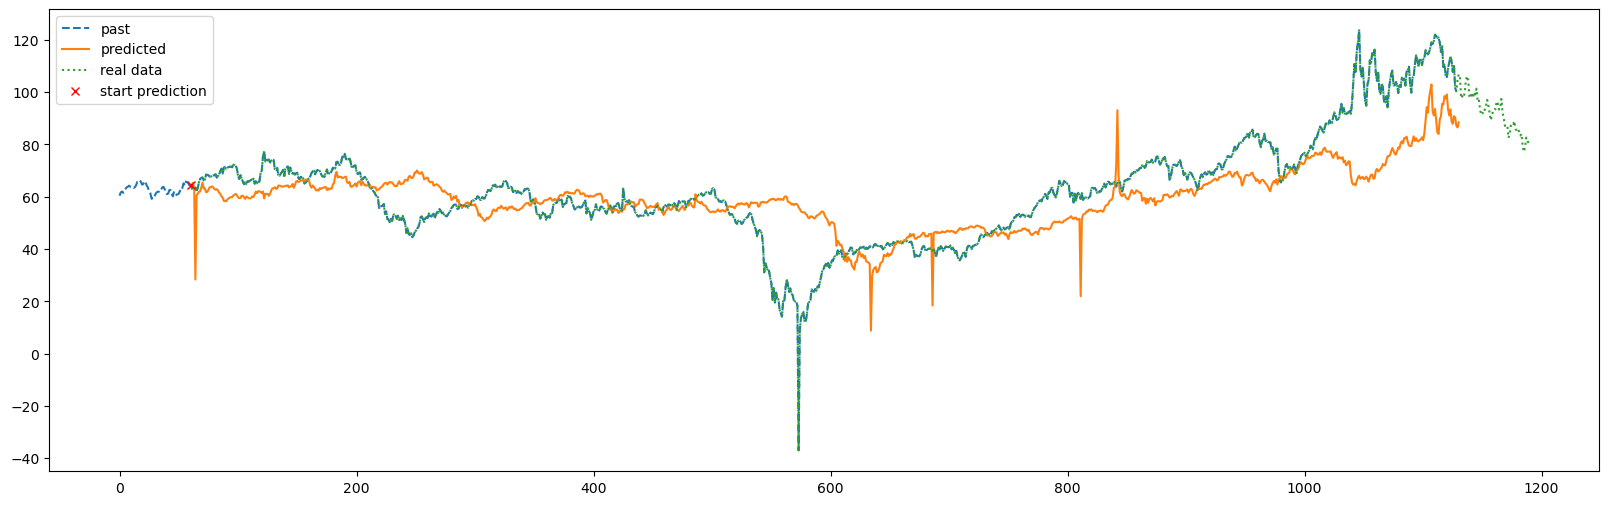

In [29]:
plot(
    wti_prediction_days.inverse_transform_numpy_array(x_train[:,0]),
    wti_prediction_days.inverse_transform_numpy_array(predicted_dataset_train[:,0]),
    wti_prediction_days.inverse_transform_numpy_array(y_train)
    #limit_right=400
)

In [30]:
predicted_dataset_test = model.predict(dataset_test)

6/6 [==============================] - 0s 27ms/step


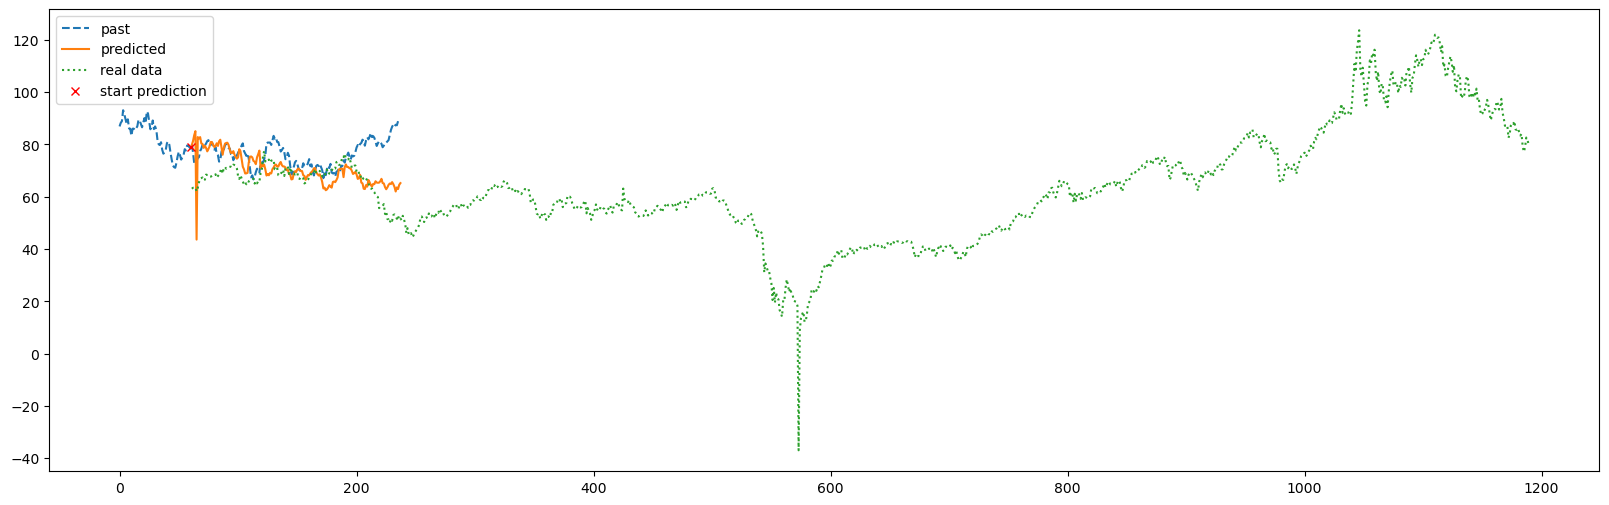

In [31]:
plot(
    wti_prediction_days.inverse_transform_numpy_array(x_test[:,0]),
    wti_prediction_days.inverse_transform_numpy_array(predicted_dataset_test[:,0]), 
    wti_prediction_days.inverse_transform_numpy_array(y_train), 
    #limit_right=400
)